# **<h3 align="center"> Capstone Project</h3>**
## **<h3 align="center">Clustering</h3>**
**Group members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Ilona Nacu - 20211602@novaims.unl.pt - 20211602<br>
Francisco Farinha - 20211550@novaims.unl.pt - 20211550<br>
João Barradas - 20211590@novaims.unl.pt - 20211590<br>
Rafael Proença  - 2021681@novaims.unl.pt - 2021681<br>

## Introduction
After generating the data we will do clustering to use in the classification problem.
| Feature               | Description                                                                                            |
|-----------------------|--------------------------------------------------------------------------------------------------------|
| id                    | Unique identifier for each user                                                                         |
| username              | Username associated with the user's account                                                            |
| age                   | Age of the user (encoded as a numerical value)                                                          |
| gender                | Gender of the user (M/F or other categorical values)                                                    |
| fav_entertainment     | Preferred types of entertainment (TV_shows, Books, Movies)                                                  |
| least_fav_entertainment | Types of entertainment the user dislikes the most (TV_shows, Books, Movies)                               |
| likes                 | Genres or entertainment categories the user generally likes ('Animation', 'Classics', 'Fantasy', 'Documentary', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Comedy', 'Drama', 'Action', 'Horror', 'Adventure', 'History')                   |
| dislikes              | Genres or entertainment categories the user generally dislikes ('Animation', 'Classics', 'Fantasy', 'Documentary', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Comedy', 'Drama', 'Action', 'Horror', 'Adventure', 'History')                  |
| movie_watching_freq   | Frequency of movie watching (Daily, Weekly, Monthly, Rarely, Never)                                                     |
| show_watching_freq    | Frequency of TV show watching (Daily, Weekly, Monthly, Rarely, Never)                                                     |
| reading_freq          | Frequency of reading activities (Daily, Weekly, Monthly, Rarely, Never)                                                     |


----------------------
## Imports
In the following cell we will select the needed imports to run this notebook.


In [25]:
# Standard libraries
import sqlite3
import warnings

# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and dimensionality reduction libraries
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import umap
import umap.umap_ as umap_umap  # Renamed to avoid conflicts with the umap module

# Suppress warnings if necessary
warnings.filterwarnings("ignore")

----------------------------
## Loading the Database
Since we already generate users data we will call the database to use in this notebook.

In [2]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('Data/users_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Query to retrieve table names from the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for name in table_names:
    print(name[0])

Users


In [3]:
# Read data from the database into a DataFrame
users = pd.read_sql('SELECT * FROM Users', conn)

# Close the cursor and connection
cursor.close()
conn.close()

In [4]:
users.head(3)

,id,username,age,gender,fav_entertainment,least_fav_entertainment,likes,dislikes,movie_watching_freq,show_watching_freq,reading_freq
0,1,Roger7748,27,F,"Books, Movies",None,"Thriller, Drama","Classics, Action",Weekly,Rarely,Monthly
1,2,Anthony6859,32,F,Books,None,"Fantasy, Romance, Drama, Thriller, Animation","Sci-Fi, Horror, Action, Adventure",Monthly,Monthly,Daily
2,3,Joe6044,30,F,Movies,Books,"Drama, Fantasy, Comedy, Romance","Classics, Adventure, History, Sci-Fi",Daily,Monthly,Rarely


-------------------------
## Preprocessing of Users DataBase
Firstly we will drop some unnecessary columns like id.

In [5]:
users_encoded= users.copy()

In [6]:
users_encoded = users_encoded.drop(columns=['id'])

In [7]:
users_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   username                 10000 non-null  object
 1   age                      10000 non-null  int64 
 2   gender                   10000 non-null  object
 3   fav_entertainment        10000 non-null  object
 4   least_fav_entertainment  10000 non-null  object
 5   likes                    10000 non-null  object
 6   dislikes                 10000 non-null  object
 7   movie_watching_freq      10000 non-null  object
 8   show_watching_freq       10000 non-null  object
 9   reading_freq             10000 non-null  object
dtypes: int64(1), object(9)
memory usage: 781.4+ KB


To clustering we need to pass the categorical features to numerical. For this we will use pd.Categorical and pd.get_dummies.

In [8]:
users_encoded['gender'] = pd.Categorical(users_encoded['gender']).codes
label_encoder = LabelEncoder()
users_encoded['age'] = label_encoder.fit_transform(users_encoded['age'])


In [9]:
# Preprocess the columns to standardize the combinations
users_encoded['fav_entertainment'] = users_encoded['fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['least_fav_entertainment'] = users_encoded['least_fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'fav_entertainment' column
fav_encoded = users_encoded['fav_entertainment'].str.get_dummies(', ').add_prefix('fav_')

# One-hot encode 'least_fav_entertainment' column
least_fav_encoded = users_encoded['least_fav_entertainment'].str.get_dummies(', ').add_prefix('least_fav_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, fav_encoded, least_fav_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['fav_entertainment', 'least_fav_entertainment'], axis=1, inplace=True)

In [10]:
# Preprocess the columns to standardize the combinations
users_encoded['likes'] = users_encoded['likes'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['dislikes'] = users_encoded['dislikes'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'likes' column
likes_encoded = users_encoded['likes'].str.get_dummies(', ').add_prefix('likes_')

# One-hot encode 'dislikes' column
dislikes_encoded = users_encoded['dislikes'].str.get_dummies(', ').add_prefix('dislikes_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, likes_encoded, dislikes_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['likes', 'dislikes'], axis=1, inplace=True)

In [11]:
# Define the encoding map
encoding_map = {'Never': 0, 'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}

# Apply the mapping to encode the variables in users_encoded
users_encoded['movie_watching_freq'] = users_encoded['movie_watching_freq'].map(encoding_map)
users_encoded['show_watching_freq'] = users_encoded['show_watching_freq'].map(encoding_map)
users_encoded['reading_freq'] = users_encoded['reading_freq'].map(encoding_map)

Now that we preprocessed the users dataset. We will check it.

In [12]:
users_encoded.head(3)

,username,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,...,dislikes_Comedy,dislikes_Documentary,dislikes_Drama,dislikes_Fantasy,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller
0,Roger7748,9,0,3,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anthony6859,14,0,2,2,4,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,Joe6044,12,0,4,2,1,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0


In [13]:
users_encoded.columns

Index(['username', 'age', 'gender', 'movie_watching_freq',
       'show_watching_freq', 'reading_freq', 'fav_Books', 'fav_Movies',
       'fav_Tv-shows', 'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History',
       'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi',
       'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure',
       'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy',
       'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy',
       'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery',
       'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller'],
      dtype='object')

## Clustering
The following loop calculates the inertia, which represents the sum of squared distances of samples to their closest cluster center, for different values of 'k' (number of clusters) using the Elbow Method. Starting from 1 and iterating up to 19 clusters, the loop performs K-means clustering for each 'k' value and computes the inertia. This metric quantifies the compactness of clusters, aiming to find the optimal number of clusters. By plotting the inertia against the number of clusters, the Elbow Method helps visualize a point where adding more clusters doesn't significantly decrease the inertia, indicating a potential optimal 'k' value.

In [14]:
data_clustering = users_encoded[['age', 'gender', 'movie_watching_freq',
       'show_watching_freq', 'reading_freq', 'fav_Books', 'fav_Movies',
       'fav_Tv-shows', 'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History',
       'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi',
       'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure',
       'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy',
       'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy',
       'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery',
       'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller']]

In [15]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_clustering)
    dispersion.append(kmeans.inertia_)

c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppr

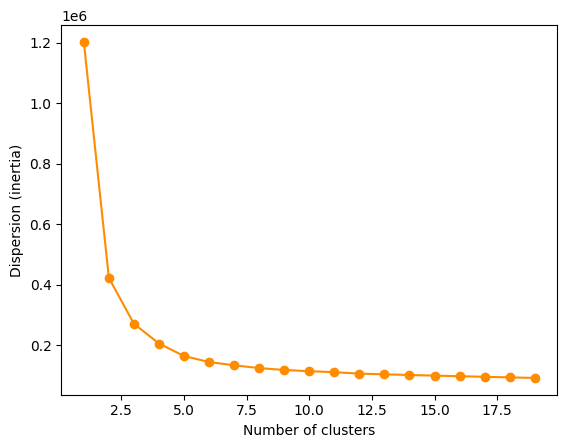

In [16]:
plt.plot(range(1, 20), dispersion, marker='o', color='darkorange')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

Through the Elbow Curve we decided that the optimum number of clusters will be five.

In [17]:
kmeans_solution = KMeans(n_clusters=5, random_state=42).fit(data_clustering)
cluster_labels = kmeans_solution.predict(data_clustering)
cluster_labels += 1  # Add 1 to shift the labels from 0-4 to 1-5
data_clustering['cluster'] = cluster_labels

c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


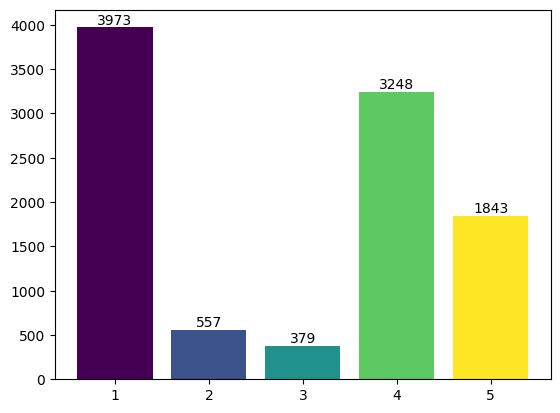

In [36]:
# Assuming 'cluster_counts' contains the counts for each cluster
cluster_counts = data_clustering.groupby('cluster').size()

# Create a colormap using 'viridis'
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))

# Create the bar plot and assign colors to bars
fig, ax = plt.subplots()
bars = ax.bar(cluster_counts.index, cluster_counts, color=colors)

# Add text annotations above each bar
for bar, count in zip(bars, cluster_counts):
    ax.text(bar.get_x() + bar.get_width()/2, count, str(count),
            ha='center', va='bottom')

# Display the plot
plt.show()


Now we will create a new column in our dataset with the correspondent cluster.

In [19]:
cluster_kmeans = data_clustering['cluster']

--------------
## Exploring Clusters through Dimensionality Reduction Techniques
> ### t-SNE Visualization:
This section utilizes t-SNE (t-Distributed Stochastic Neighbor Embedding) to visually represent the high-dimensional feature space in a two-dimensional plane. The code collects the clustered data to the driver node, performs t-SNE transformation, and generates a scatter plot to display the data points in the new space. Each data point is colored according to its predicted cluster.

In [20]:
tsne_model_ = TSNE(n_components=2, perplexity=100, random_state=42)
tsne_cust = tsne_model_.fit_transform(data_clustering)

In [21]:
def visualize_dimensionality_reduction(data, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title('Dimensionality Reduction Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

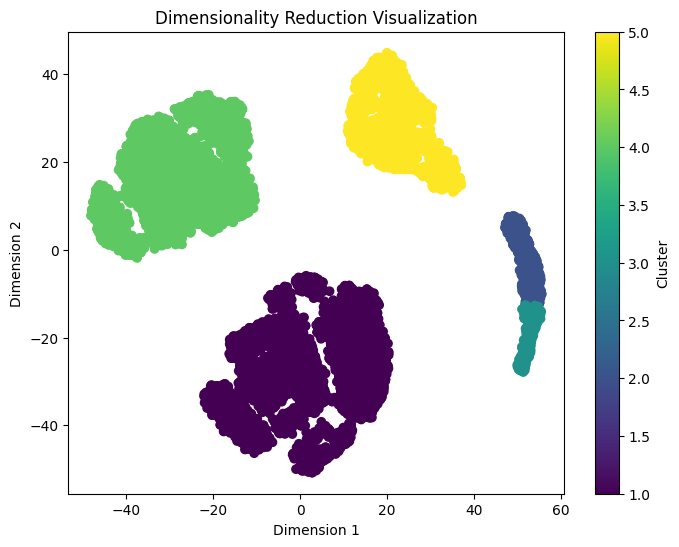

In [22]:
# visualize_dimensionality_reduction(tsne_cust, np.array(data_clustering))
# Ensure 'labels' matches the number of points in tsne_cust
visualize_dimensionality_reduction(tsne_cust, cluster_kmeans)

> ### UMAP Visualization:
This part employs UMAP (Uniform Manifold Approximation and Projection) to visualize the dataset in a reduced dimensional space. UMAP provides another perspective on the dataset's structure, plotting it in a two-dimensional representation. Similar to the t-SNE plot, the UMAP plot depicts clusters based on their distribution in this reduced space.

In [43]:
umap_object = umap.UMAP(n_neighbors=50, min_dist=0.7, random_state=42)

In [44]:
%%time
umap_embedding = umap_object.fit_transform(data_clustering)

c:\Users\xandg\Ambiente de Trabalho\IMS\3rd year\1st Semester\Capstone Project\OpenAI\Capstone-Project\env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: total: 20.3 s
Wall time: 51 s


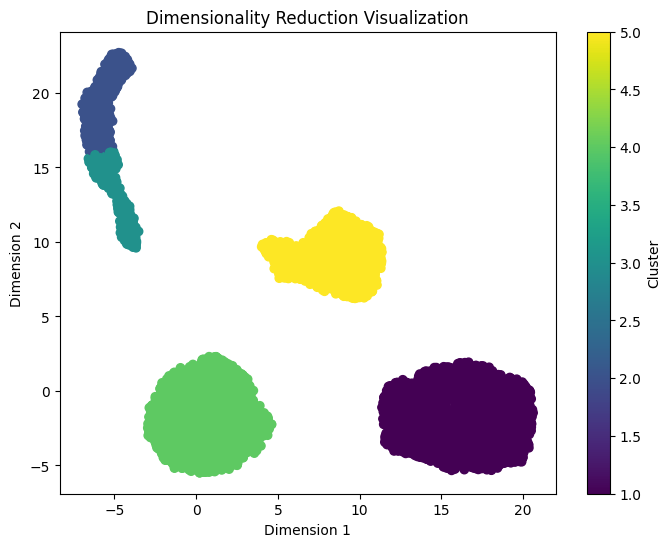

In [45]:
visualize_dimensionality_reduction(umap_embedding, np.array(cluster_kmeans))

---
# Statistical Insights and Central Tendencies
This section computes statistics like mean and mode per cluster utilizing aggregation functions. 
The enhanced description highlights how this code snippet conducts in-depth analysis per cluster, uncovering significant statistical insights across various metrics and categorical attributes within the clustered dataset.




In [46]:
# Define the reverse mapping by swapping keys and values
reverse_encoding_map = {v: k for k, v in encoding_map.items()}

# Apply the reverse mapping to decode the variables
data_clustering['movie_watching_freq'] = data_clustering['movie_watching_freq'].map(reverse_encoding_map)
data_clustering['show_watching_freq'] = data_clustering['show_watching_freq'].map(reverse_encoding_map)
data_clustering['reading_freq'] = data_clustering['reading_freq'].map(reverse_encoding_map)

In [47]:
data_clustering['age'] = label_encoder.inverse_transform(data_clustering['age'])

In [50]:
# Group by 'cluster' and calculate descriptive statistics for each feature
grouped_stats = data_clustering.groupby('cluster').agg({
    'age': lambda x: x.mode().iloc[0],
    'gender': 'mean',
    'movie_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of movie_watching_freq by cluster
    'show_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of show_watching_freq by cluster
    'reading_freq': lambda x: x.mode().iloc[0],  # Frequencies of reading_freq by cluster
    'fav_Books': 'mean',
    'fav_Movies': 'mean',
    'fav_Tv-shows': 'mean',
    'least_fav_Books': 'mean',
    'least_fav_Movies': 'mean',
    'least_fav_None': 'mean',
    'least_fav_Tv-shows': 'mean',
    'likes_Action': 'mean',
    'likes_Adventure': 'mean',
    'likes_Animation': 'mean',
    'likes_Classics': 'mean',
    'likes_Comedy': 'mean',
    'likes_Documentary': 'mean',
    'likes_Drama': 'mean',
    'likes_Fantasy': 'mean',
    'likes_History': 'mean',
    'likes_Horror': 'mean',
    'likes_Mystery': 'mean',
    'likes_Romance': 'mean',
    'likes_Sci-Fi': 'mean',
    'likes_Thriller': 'mean',
    'dislikes_Action': 'mean',
    'dislikes_Adventure': 'mean',
    'dislikes_Animation': 'mean',
    'dislikes_Classics': 'mean',
    'dislikes_Comedy': 'mean',
    'dislikes_Documentary': 'mean',
    'dislikes_Drama': 'mean',
    'dislikes_Fantasy': 'mean',
    'dislikes_History': 'mean',
    'dislikes_Horror': 'mean',
    'dislikes_Mystery': 'mean',
    'dislikes_Romance': 'mean',
    'dislikes_Sci-Fi': 'mean',
    'dislikes_Thriller': 'mean',
})

# Creating a DataFrame from the computed statistics
db_clusters_df = pd.DataFrame(grouped_stats)

# Rounding the values to two decimal places
db_clusters_df = db_clusters_df.round(2)

# Displaying the resulting dataset
db_clusters_df.T


cluster,1,2,3,4,5
age,27,44,60,25,32
gender,0.62,0.66,0.64,0.62,0.62
movie_watching_freq,Daily,Never,Never,Daily,Monthly
show_watching_freq,Never,Weekly,Daily,Daily,Never
reading_freq,Weekly,Weekly,Monthly,Never,Monthly
fav_Books,0.74,0.73,0.73,0.0,0.74
fav_Movies,0.77,0.0,0.0,0.72,0.72
fav_Tv-shows,0.0,0.76,0.76,0.76,0.03
least_fav_Books,0.09,0.09,0.08,0.42,0.08
least_fav_Movies,0.08,0.41,0.44,0.1,0.09


 ### Cluster 1 - Daily Diverse Explorer
- **Movie Watching:** Daily
- **Show Watching:** Never
- **Reading Frequency:** Weekly
- **Preferred Entertainment Method:** Books & Movies
- **Least Preferred Method:** TV Shows
- **Favorite Genres:** Thriller, Action, Mystery
- **Disliked Genres:** Drama, Romance, Fantasy

**Small Description**- Cluster 1, the "Daily Diverse Explorer," comprises individuals exhibiting a varied content consumption pattern. These users engage in daily movie watching and have a penchant for exploring the world of books and movies, aligning with a weekly reading frequency. Their preference leans strongly towards genres that evoke excitement and suspense, favoring Thriller, Action, and Mystery. However, they exhibit a discernible aversion to genres associated with emotional depth and fantasy elements, disliking Drama, Romance, and Fantasy. Notably, their least preferred entertainment method appears to be TV shows, suggesting a predilection for the immersive experiences offered by books and movies over episodic narratives typically found in TV series. 
<br>
<br>
<br>


### Cluster 2 - Literary Historians
- **Movie Watching:** Never
- **Show Watching:** Weekly
- **Reading Frequency:** Weekly
- **Preferred Entertainment Method:** TV Shows & Books
- **Least Preferred Method:** Movies and None (balanced)
- **Favorite Genres:** History, Classics
- **Disliked Genres:** Mystery, Documentary, Thriller

**Small Description** - Cluster 2, known as the "Literary Historians," embodies a distinct entertainment pattern characterized by a commitment to regular reading and weekly engagement with TV shows. These individuals showcase a particular affinity for historical and classic genres, indicating a shared interest in narratives rooted in history and traditional literary works. Their preference for historical content aligns seamlessly with their reading habits, emphasizing an inclination toward exploring historical themes across different entertainment mediums. Notably, their aversion to Mystery and Documentary genres underscores a specific taste for storytelling focused on historical and classic elements rather than mystery or factual narratives.
<br>
<br>
<br>

### Cluster 3 - Cultural Connoisseurs
- **Movie Watching:** Never
- **Show Watching:** Daily
- **Reading Frequency:** Monthly
- **Preferred Entertainment Method:** TV Shows & Books
- **Least Preferred Method:** Movies
- **Favorite Genres:**  Classics, History and Sci fi
- **Disliked Genres:** Mystery, Documentary, Thriller

**Small Description** - Cluster 3, identified as the "Cultural Connoisseurs," exhibits distinctive entertainment habits and genre preferences. These individuals actively engage in daily TV show viewing, showcasing a consistent interest in screen-based entertainment. While their reading frequency is less frequent, they still demonstrate an occasional engagement with books. Their preference for Classics, History, and Sci-Fi genres indicates a fascination with narratives deeply rooted in cultural heritage, historical contexts, and speculative futuristic themes. Notably, their avoidance of Mystery, Documentary, and Thriller genres suggests a deliberate choice to steer away from intense, suspenseful, or factual storytelling, emphasizing a preference for culturally enriching and speculative narratives across their preferred mediums of entertainment.
<br>
<br>
<br>


### Cluster 4 - Screen Entertainment Enthusiasts
- **Movie Watching:** Daily
- **Show Watching:** Daily
- **Reading Frequency:** Never
- **Preferred Entertainment Method:** Movies & TV Shows
- **Least Preferred Method:** Books
- **Favorite Genres:** Action, Adventure, Horror, Sci-Fi
- **Disliked Genres:** Classics, Documentary, History, Mystery and Thriller

**Small Description** - Cluster 4, known as "Screen Entertainment Enthusiasts," comprises individuals deeply passionate about screen-based entertainment. They indulge in daily movie and TV show viewing, finding joy and excitement in action-packed, thrilling, and imaginative narratives found in genres like action, adventure, horror, and sci-fi. Their preference leans heavily towards visual storytelling, as they rarely engage with books. Notably, they prefer content that offers adrenaline-pumping experiences but tends to avoid genres associated with historical, classic, factual, or suspenseful storytelling, seeking entertainment that captivates and exhilarates their senses.
<br>
<br>
<br>



### Cluster 5 - Cinematic Bookworms
- **Movie Watching:** Monthly
- **Show Watching:** Never
- **Reading Frequency:** Monthly
- **Preferred Entertainment Method:** Books and Movies
- **Least Preferred Method:** TV Shows
- **Favorite Genres:** Drama, Thriller and Mystery
- **Disliked Genres:** Classics and History

**Small description**- Cluster 5, known as "Cinematic Bookworms," represents individuals who immerse themselves in stories through a balanced engagement with books and occasional movies while steering clear of TV shows. Their monthly routine involves both reading and watching movies, showcasing a fondness for narrative-driven entertainment. They exhibit a clear preference for gripping genres such as Drama, Thriller, and Mystery, which captivate their imagination and keep them engaged in the stories they consume. Notably, they avoid genres associated with historical or traditional storytelling, preferring narratives that offer suspense, intrigue, and emotional depth. This cluster's entertainment habits underscore a deliberate choice for immersive storytelling experiences found in both books and selected cinematic narratives.

Now we will create the feature CritiPersonality.

-------
## Saving the Data 

In [ ]:
data_clustering.head(3)

,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,least_fav_Movies,...,dislikes_Drama,dislikes_Fantasy,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller,cluster,CritiPersonality
0,27,0,Weekly,Rarely,Monthly,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,daily diverse explorer
1,32,0,Monthly,Monthly,Daily,1,0,0,0,0,...,0,0,0,1,0,0,1,0,5,cinematic bookworms
2,30,0,Daily,Monthly,Rarely,0,1,0,1,0,...,0,0,1,0,0,0,1,0,1,daily diverse explorer


In [128]:
#export data for builiding the classification model
data_clustering.to_csv('Data/classification_data.csv', index=False)